In [12]:
# Import
import os
import sys
sys.path.append('/home/user/workdir/CMAQ_Emulator/main')

# 모델 라이브러리
# from src.model.cmaqnet_cond_unet import build_model

# 학습 및 처리/분석 관련 라이브러리
import numpy as np
import pandas as pd
import netCDF4 as nc
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score

# Geometric 및 시각화 라이브러리
import geopandas as gpd
from shapely.geometry import Point
import matplotlib as mpl
import matplotlib.pyplot as plt

# 2D Map 결과 도출을 위한 지도 파라미터 세팅
proj = '+proj=lcc +lat_1=30 +lat_2=60 +lon_1=126 +lat_0=38 +lon_0=126 +ellps=GRS80 +units=m'
atob = {
    0: 'G', 1: 'F', 2: 'K', 3: 'J', 4: 'E', 5: 'D',
    6: 'O', 7: 'C', 8: 'A', 9: 'Q', 10: 'P', 11: 'B',
    12: 'M', 13: 'L', 14: 'N', 15: 'I', 16: 'H'}
region_columns = {
    'A': 'Seoul City', 'B': 'Incheon City', 'C': 'Busan City', 'D': 'Daegu City',
    'E': 'Gwangju City', 'F': 'Gyeonggi-do', 'G': 'Gangwon-do', 'H': 'Chungbuk-do',
    'I': 'Chungnam-do', 'J': 'Gyeongbuk-do', 'K': 'Gyeongnam-do', 'L': 'Jeonbuk-do',
    'M': 'Jeonnam-do', 'N': 'Jeju-do', 'O': 'Daejeon City', 'P': 'Ulsan City', 'Q': 'Sejong City'}

def get_ctprvn_map() -> gpd.GeoDataFrame:
    path = '/home/user/workdir/CMAQ_Emulator/main/resources/geom/ctp_rvn.shp'
    ctprvn = gpd.GeoDataFrame.from_file(path, encoding='cp949')
    ctprvn.crs = 'EPSG:5179'
    return ctprvn

def get_base_raster(ctprvn:gpd.GeoDataFrame) -> gpd.GeoDataFrame:
    points = [Point(i, j)
                for i in range(-180000, -180000 + 9000 * 67, 9000)
                for j in range(-585000, -585000 + 9000 * 82, 9000)]
    grid_data = gpd.GeoDataFrame(points, geometry='geometry', columns=['geometry'])
    grid_data.crs = ctprvn.to_crs(proj).crs
    grid_data.loc[:,'x_m'] = grid_data.geometry.x
    grid_data.loc[:,'y_m'] = grid_data.geometry.y
    grid_data.loc[:,'value'] = 0
    grid_data.loc[:,'index'] = grid_data.index
    return grid_data

def get_region_pixel_indices() -> list:
    ctprvn = get_ctprvn_map()
    grid_data = get_base_raster(ctprvn)

    cities = {
        0: '강원도', 1: '경기도', 2: '경상남도', 3: '경상북도',
        4: '광주광역시', 5: '대구광역시', 6: '대전광역시', 7: '부산광역시',
        8: '서울특별시', 9: '세종특별자치시', 10: '울산광역시', 11: '인천광역시',
        12: '전라남도', 13: '전라북도', 14: '제주특별자치도', 15: '충청남도',
        16: '충청북도'
    }

    gdf_joined_loc = ['CTPRVN_CD', 'CTP_ENG_NM', 'CTP_KOR_NM', 'index_right0']
    gdf_joined = gpd.sjoin(ctprvn, grid_data.to_crs(5179), predicate='contains')

    indices = gpd.GeoDataFrame(pd.merge(
        left=grid_data, right=gdf_joined.loc[:,gdf_joined_loc], 
        how='left', left_on='index', right_on='index_right0'
    ), geometry='geometry').dropna()
    pixel_indices = \
        [[(idx%82, idx//82) for idx in indices.loc[indices.CTP_KOR_NM==cities[region]].index.tolist()]
         for region, _ in cities.items()]
    return pixel_indices

ctprvn = get_ctprvn_map()
ctprvn_proj = ctprvn.to_crs(proj)

# 건국대(서울대)에서 제공한 대한민국 국토 grid 정보
grid_alloc = (
    pd.read_csv('/home/user/workdir/CMAQ_Emulator/main/resources/geom/grid_allocation.csv') # load grid allocation data
    .sort_values(by=['Row', 'Column', 'Ratio'], ascending=[True, True, False]) # sort by row, column, ratio
    .drop_duplicates(subset=['Row', 'Column'], keep='first') # drop duplicates
    .reset_index(drop=True) # reset index
)

# 정부에서 배포하는 대한민국 국토 grid 정보
pixel_indices = get_region_pixel_indices()
total_index = []
for idx, grids in enumerate(pixel_indices):
    for grid in grids:
        total_index.append([
            grid[1], grid[0], 100.0, atob[idx], region_columns[atob[idx]]
        ])
total_index = pd.DataFrame(total_index, columns=grid_alloc.columns)

# 두 기관에서 주는 grid에 한두픽셀씩 비어있는 부분이 있어, 두 기관 데이터를 모두 참조하여 중복되는 픽셀을 정리 후 최종 국토 grid 정보를 취득
grid_alloc = pd.concat([
    grid_alloc.drop(columns=['Ratio', 'Region_Name']),
    total_index.drop(columns=['Ratio', 'Region_Name'])
]).sort_values(by=['Region_Code']).drop_duplicates().reset_index(drop=True)
grid_alloc[['Row', 'Column']] = grid_alloc[['Row', 'Column']] - 1

row_indices, col_indices = zip(*grid_alloc[['Row', 'Column']].values)
offset_x, offset_y = 4500, 4500 # 지도 위치 맞추기

# 마스킹 처리
mask = np.zeros((82, 67))
mask[row_indices, col_indices] = 1

cmap_white = mpl.colormaps['jet']
cmap_white.set_under('white')

In [13]:
test_split = 0.2  # 테스트 데이터 비율 (20%)
random_seed = 42  # 랜덤 시드

gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        print("Memory growth enabled for GPUs")
    except RuntimeError as e:
        print(e)

strategy = tf.distribute.MirroredStrategy()
with strategy.scope():
    model = tf.keras.models.load_model('/home/user/workdir/CMAQ_Emulator/main/src/model/nitrate_prediction/final_model_v2')

# 입력 데이터셋 로드
emis_ctrl_2019_05 = pd.read_csv('/home/user/workdir/CMAQ_Emulator/main/resources/ctrl/precursor_control_2019_nitrate.csv')
emis_ctrl_2019_05['Boundary'] = 0.5
''' 0.6, 0.7, 0.75, 0.8, 0.85 condition 추가'''
emis_ctrl_2019_06 = emis_ctrl_2019_05.copy()
emis_ctrl_2019_06['Boundary'] = 0.6
emis_ctrl_2019_07 = emis_ctrl_2019_05.copy()
emis_ctrl_2019_07['Boundary'] = 0.7
emis_ctrl_2019_075 = emis_ctrl_2019_05.copy()
emis_ctrl_2019_075['Boundary'] = 0.75
emis_ctrl_2019_08= emis_ctrl_2019_05.copy()
emis_ctrl_2019_08['Boundary'] = 0.8
emis_ctrl_2019_085= emis_ctrl_2019_05.copy()
emis_ctrl_2019_085['Boundary'] = 0.85
emis_ctrl_2019_10 = emis_ctrl_2019_05.copy()
emis_ctrl_2019_10['Boundary'] = 1.0
ctrl_data = pd.concat([
    emis_ctrl_2019_05,
    emis_ctrl_2019_06,
    emis_ctrl_2019_07,
    emis_ctrl_2019_075,
    emis_ctrl_2019_08,
    emis_ctrl_2019_085,
    emis_ctrl_2019_10
], axis=0)
ctrl_data = ctrl_data.reset_index(drop=True).values
pred_emis_data, pred_boundary_data = ctrl_data[:, :17*5], ctrl_data[:, 17*5]

_, X_emis_test, _, X_boundary_test = train_test_split(pred_emis_data, pred_boundary_data, test_size=test_split, random_state=random_seed, stratify=pred_boundary_data)

y_preds = model.predict([X_emis_test,  X_boundary_test])
y_pred = y_preds.squeeze()

Memory growth enabled for GPUs
INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1', '/job:localhost/replica:0/task:0/device:GPU:2', '/job:localhost/replica:0/task:0/device:GPU:3')
6/6 [==============================] - 3s 21ms/step


In [14]:
boundary_vals = X_boundary_test.squeeze()  # shape: (n_samples,)
predicted_means = np.mean(y_pred, axis=(1,2))  # (n_samples,)

xmin = np.min(boundary_vals)
xmax = np.max(boundary_vals)

In [15]:
def get_region_mask(row_start, row_end, col_start, col_end):
    """
    row_start~row_end, col_start~col_end 범위를 True로 만드는
    82×67 boolean mask를 생성
    """
    mask_region = np.zeros((82, 67), dtype=bool)
    mask_region[row_start:row_end, col_start:col_end] = True
    return mask_region

def get_region_mask_by_code(region_code, full_mask_shape=(82,67)):
    """
    region_code: 예) 'A' (Seoul), 'B' (Incheon), ...
    full_mask_shape: (82,67)

    grid_alloc에 Region_Code == region_code인 행/열 인덱스만 True
    """
    mask_region = np.zeros(full_mask_shape, dtype=bool)

    # grid_alloc에서 region_code에 해당하는 행,열 리스트를 얻어옴
    region_rows = grid_alloc.loc[grid_alloc['Region_Code'] == region_code, 'Row'].values
    region_cols = grid_alloc.loc[grid_alloc['Region_Code'] == region_code, 'Column'].values

    for r, c in zip(region_rows, region_cols):
        mask_region[r, c] = True
    return mask_region

def compute_regional_mean(y_pred, region_mask):
    """
    y_pred: 예) shape (n_samples, 82, 67, 1) 또는 (n_samples, 82, 67)
    region_mask: shape (82,67) boolean mask
    return: shape (n_samples,) - 해당 region의 평균값
    """
    # region_mask를 (1,82,67)로 확장하고 배치 차원에 맞게 반복
    mask_expanded = np.expand_dims(region_mask, axis=0)  # (1,82,67)
    mask_expanded = np.repeat(mask_expanded, repeats=y_pred.shape[0], axis=0)  # (n_samples,82,67)

    # y_pred의 마지막 축이 1인 경우만 squeeze, 그렇지 않으면 그대로 사용
    if y_pred.ndim == 4 and y_pred.shape[-1] == 1:
        y_pred_squeezed = y_pred.squeeze(-1)  # (n_samples,82,67)
    elif y_pred.ndim == 3:
        y_pred_squeezed = y_pred  # 이미 (n_samples,82,67)
    else:
        raise ValueError(f"y_pred shape must be (n_samples,82,67) or (n_samples,82,67,1). Got {y_pred.shape}")

    # region_mask에서 True인 부분만 추출하고 평균 계산
    region_values = np.ma.masked_where(~mask_expanded, y_pred_squeezed)
    regional_mean = region_values.mean(axis=(1,2))  # (n_samples,)

    return regional_mean.data  # np.array 반환


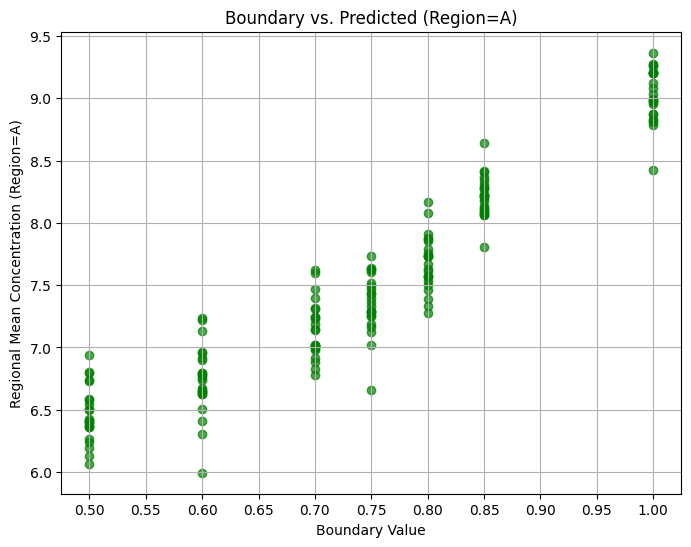

In [16]:
# 지역별 평균 농도 vs. Boundary 값

# 'A': 'Seoul City', 'B': 'Incheon City', 'C': 'Busan City', 'D': 'Daegu City',
# 'E': 'Gwangju City', 'F': 'Gyeonggi-do', 'G': 'Gangwon-do', 'H': 'Chungbuk-do',
# 'I': 'Chungnam-do', 'J': 'Gyeongbuk-do', 'K': 'Gyeongnam-do', 'L': 'Jeonbuk-do',
# 'M': 'Jeonnam-do', 'N': 'Jeju-do', 'O': 'Daejeon City', 'P': 'Ulsan City', 'Q': 'Sejong City'

region_code = 'A'
region_mask = get_region_mask_by_code(region_code)  # 예: 서울시
regional_means = compute_regional_mean(y_pred, region_mask)  # (n_samples,)

plt.figure(figsize=(8,6))
plt.scatter(boundary_vals, regional_means, alpha=0.7, color='green')
plt.xlabel("Boundary Value")
plt.ylabel(f"Regional Mean Concentration (Region={region_code})")
plt.title(f"Boundary vs. Predicted (Region={region_code})")
plt.grid(True)
plt.xticks(np.arange(xmin, xmax + 0.05, 0.05))
plt.show()

In [17]:
def sensitivity_analysis_single_var(
    model, base_input, base_condition, var_index, var_range, boundary_index=None
):
    """
    model: 학습된 모델 (callable), 두 개의 입력 [control, condition]을 받음.
    base_input: shape (ctrl_dim,) 기준 벡터 (control input)
    base_condition: shape (cond_dim,) 기준 벡터 (condition input)
    var_index: 변화시킬 변수의 index (0 ~ ctrl_dim-1)
    var_range: 예: np.linspace(0.5, 1.5, 11)
    boundary_index: 만약 condition input에서 boundary의 위치가 다르면 사용 (여기서는 생략)
    
    return:
        var_values: list of varied variable values
        y_outputs: shape (len(var_range), 82, 67, 1)
    """
    y_outputs = []
    for val in var_range:
        # control input 복사 후 target variable 변경
        new_control = base_input.copy()
        new_control[var_index] = val

        # 배치 차원 추가
        new_control_batch = np.expand_dims(new_control, axis=0)  # (1, ctrl_dim)
        new_condition_batch = np.expand_dims(base_condition, axis=0)  # (1, cond_dim)

        # 모델 예측: 두 개의 입력을 리스트로 전달
        y_pred = model.predict([new_control_batch, new_condition_batch])
        y_outputs.append(y_pred[0])  # (82,67,1)
        
    y_outputs = np.array(y_outputs)  # shape (len(var_range), 82,67,1)
    return var_range, y_outputs

# 예시 사용:
# 1) base_input 만들기 (control input)
base_input = np.ones((17*5,), dtype=np.float32)  # 모든 값 1.0
# 2) base_condition 만들기 (조건 input, 예를 들어 boundary 값이 하나의 값으로 주어진 경우)
base_condition = np.array([1.0], dtype=np.float32)  # 예: boundary=1.0

var_index = 0  # 예: A_NOX_ALL의 위치
var_range = np.linspace(0.5, 1.5, 11)

model = tf.keras.models.load_model('/home/user/workdir/CMAQ_Emulator/main/src/model/nitrate_prediction/final_model_v2')

vals, outs = sensitivity_analysis_single_var(model, base_input, base_condition, var_index, var_range)


1/1 [==============================] - 0s 35ms/step


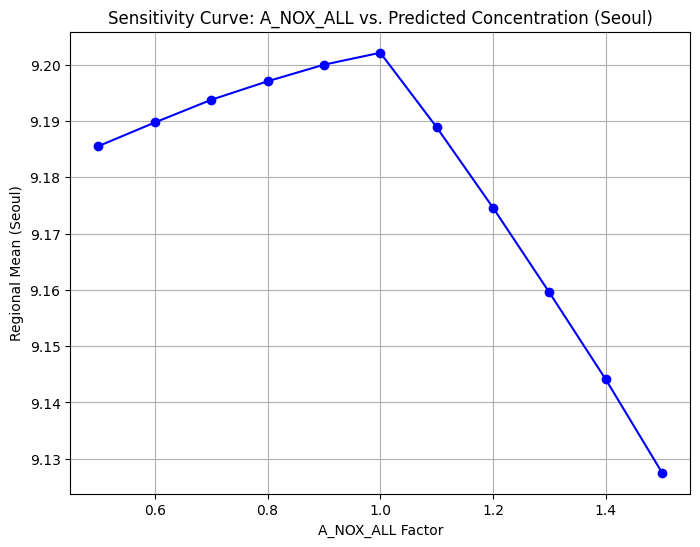

In [18]:
# 먼저, 서울시에 해당하는 마스크를 생성 (예: 'A' 지역 코드)
regional_mask = get_region_mask_by_code('A')  # get_region_mask_by_code 함수가 정의되어 있어야 함

# sensitivity_analysis_single_var() 함수로부터 얻은 결과: vals와 outs
# outs의 shape: (len(var_range), 82, 67, 1)
regional_means = []
for i in range(len(vals)):
    # 각 시나리오(배출량 factor 변화)에 대해 서울시 영역만의 평균 값을 계산
    # compute_regional_mean 함수는 (n_samples, 82,67,1) 데이터를 입력받아 (n_samples,) 배열을 반환
    regional_mean = compute_regional_mean(outs[i:i+1], regional_mask)  # 결과 shape: (1,)
    regional_means.append(regional_mean[0])

# 민감도 곡선 그리기
plt.figure(figsize=(8,6))
plt.plot(vals, regional_means, marker='o', linestyle='-', color='blue')
plt.xlabel("A_NOX_ALL Factor")
plt.ylabel("Regional Mean (Seoul)")
plt.title("Sensitivity Curve: A_NOX_ALL vs. Predicted Concentration (Seoul)")
plt.grid(True)
plt.show()
